### Chat with Data using Agents

In [1]:
import os
from dotenv import load_dotenv

# from langchain.agents import AgentType, initialize_agent, load_tools
# from langchain_community.llms import Ollama
from langchain_groq import ChatGroq

from langchain.schema import SystemMessage
from langchain.chains import LLMChain
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate

from common_functions import generate_synthetic_data, ensure_installed, \
	display_md, extract_quotes, datasets_dir

load_dotenv()

# ensure_ollama_running()
# llm_model = os.getenv('LLM_MODEL')
# llm = Ollama(model=llm_model)
llm = ChatGroq(model_name=os.getenv('GROQ_SMALL_MODEL'), temperature=1.0)
data_gen_llm = ChatGroq(model_name=os.getenv('GROQ_LARGE_MODEL'), temperature=1.0)

CODE_INTERPRETER = True
if CODE_INTERPRETER:
	ensure_installed([{ 'codeinterpreterapi[all]': 'codeinterpreterapi' }])

#### Generate synthetic data

In [2]:
topic = 'sales'
fields = ['product_id', 'sales', 'date']
examples = [{ 'example': 'product_id: 1, sales: 100, dates: any dates from 2020 to 2022' }]

data_save_path = os.path.join(datasets_dir, f'{topic}_synthetic_data.csv')
df = generate_synthetic_data(data_gen_llm, topic, rows=100, fields=fields,
								examples=examples, data_save_path=data_save_path)
df.head()

,product_id,sales,date
0,1,120,2020-01-05
1,2,80,2020-01-10
2,3,150,2020-01-15
3,1,90,2020-02-12
4,2,70,2020-02-18


#### Define a chain for asking queries

In [3]:
prompt = f'''
Act as a Data Analyst and Data Scientist for a company that uses {topic} data.
Answer the user's question using the {topic} data below. Make useful text bold or italic according to the context.

```{df.to_csv(index=False)}```
'''

chatPromptTemplate = ChatPromptTemplate(
	messages = [
		SystemMessage(prompt),
		HumanMessagePromptTemplate.from_template('{question}'),
	],
	input_variables=['query_context', 'question'],
)

chain = LLMChain(
	llm=llm,
	prompt=chatPromptTemplate,
	verbose=False,
	output_key='query_answer',
)

def ask_query(query, display=False, return_quoted=False):
	response = chain.invoke(
		{ "question": query },
		output_key="query_answer",
	)
	answer = response["query_answer"]
	if return_quoted:
		return extract_quotes(answer)
	if display:
		display_md(answer)
	else:
		return answer

/home/codespace/.python/current/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [4]:
# ask_query("What is the total sales for product 1?", display=True)

In [5]:
# ask_query("On which months are overal sales higher?", display=True)

In [6]:
# ask_query("What are the possible reasons for the drop in sales sometimes?", display=True)

#### Chatting with CSV (Similar to RAG over SQL)

/home/codespace/.python/current/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


AI:  Based on the graph, each product's sales over time are plotted, allowing us to visualize and compare the trends for all products.
File:  image-2f34fc34-ec42-4937-9998-85ae67dbf34b.png


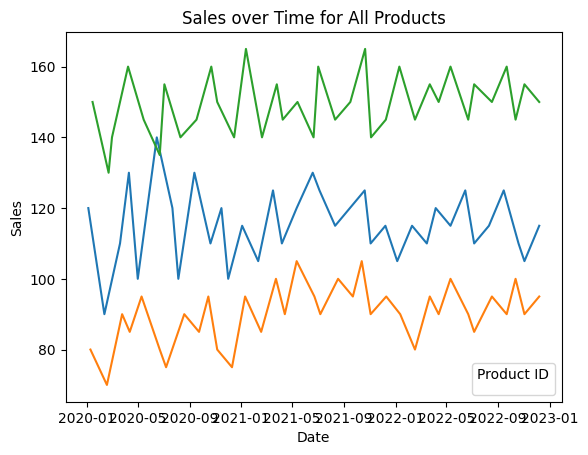

In [7]:
# create a code interpreter agent that can execute code over the data including plotting graphs

from codeinterpreterapi import CodeInterpreterSession, File
# if any issues - `rm -rf .codebox __pycache__`

with CodeInterpreterSession(llm) as session:
	response = session.generate_response(
		user_msg = 'Plot a graph to represent sales over time for all products. \n' \
					'Ignore your previous chat history completely. \n' \
					'Ensure parallel graphs for all products. \n' \
					'Use columns: ' + ', '.join(df.columns),
		files = [File.from_path(data_save_path)],
	)
	response.show()